In [76]:
import tensorflow as tf
import numpy as np
import random as rn
%matplotlib inline
import matplotlib.pyplot as plt

In [77]:
M = 16 
k = np.log2(M)
k = int(k)
n_channel = 7
R = k/n_channel
EbNodB = 5
EbNo=10.0**(EbNodB/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
noise_mean = 0

In [78]:
N = 5000
label = np.random.randint(M,size=N)

In [79]:
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
    
data = np.array(data)

In [80]:
Nt = 1000
test_label = np.random.randint(M,size=Nt)

In [81]:
test_data = []
for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [82]:
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=noise_mean, stddev=noise_std, dtype=tf.float32) 
    return input_layer + noise

In [83]:
num_inputs=M
num_hid1=n_channel
num_hid2=n_channel #corrupted num_hid1
num_output=num_inputs
lr=0.01
actf=tf.nn.relu

In [84]:
S=tf.placeholder(tf.float32,shape=[None,num_inputs])

initializer=tf.variance_scaling_initializer()

w1=tf.Variable(initializer([num_inputs,num_hid1]),dtype=tf.float32)
w2=tf.Variable(initializer([num_hid1,num_hid2]),dtype=tf.float32)
w3=tf.Variable(initializer([num_hid1,num_inputs]),dtype=tf.float32)

b1=tf.Variable(tf.zeros(num_hid1))
b2=tf.Variable(tf.zeros(num_hid2))
b3=tf.Variable(tf.zeros(num_output))

hidden1=tf.nn.relu(tf.matmul(S,w1)+b1)

channel = gaussian_noise_layer(hidden1, noise_std)

hidden2=tf.nn.relu(tf.matmul(channel,w2)+b2)

output_layer=tf.nn.softmax(tf.matmul(hidden2,w3)+b3)

In [85]:
loss=tf.reduce_mean(tf.square(output_layer-S))

optimizer=tf.train.AdamOptimizer(lr)
train=optimizer.minimize(loss)

init=tf.global_variables_initializer()

In [86]:
from collections import Counter

def calc_MI(hidden,Y):
    n_neurons = hidden.shape[1]
    
    n_train_samples=Nt
    n_bins = 30
    bins = np.linspace(0, 10, n_bins+1)
    indices = np.digitize(hidden, bins)
   
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[test_label[i]] += 1/float(n_train_samples)
        pdf_y[np.int(Y[i])] += 1/float(n_train_samples) 
        pdf_xt[(test_label[i],)+tuple(indices[i,:])] += 1/float(n_train_samples) 
        pdf_yt[(np.int(Y[i]),)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

# get mutual information for hidden layers H1 and H2, each hidden layer is a separate random variable denoted by T1 and T2
def get_MI(H1,H2,Y):
    mi_xt_list = []; mi_ty_list = []
    mi_xt, mi_ty = calc_MI(H1,Y)
    mi_xt_list.append(mi_xt)
    mi_ty_list.append(mi_ty)
    mi_xt, mi_ty = calc_MI(H2,Y)
    mi_xt_list.append(mi_xt)
    mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [87]:
episodes = 1000

# Launch the graph in a session
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    
    for e in range(episodes):
        for i in range(N):
            input_ = data[i]
            sess.run(train, feed_dict={S: [input_]})
            
    
with tf.Session() as sess:
    tf.initialize_all_variables().run()    
    
    mi_xt_all = []; mi_ty_all = []; epochs = []
    for e in range(episodes):
        H1=[]
        H2=[]
        Y=[]
        for j in range(Nt):
            input_ = test_data[j]
            h1, h2, pred_final_signal = sess.run([hidden1, hidden2, output_layer],
                                                  feed_dict={S: [input_]})
            H1.append(h1)
            H2.append(h2)
            pred_output = np.argmax(pred_final_signal,axis=1)
            Y.append(pred_output)
        H1=np.array(H1)
        H2=np.array(H2)
        H1=H1.reshape(Nt,n_channel)
        H2=H2.reshape(Nt,n_channel)
        Y=np.array(Y)
        Y=Y.reshape(Nt,1)
        if e % 2 == 0:
            mi_xt, mi_ty = get_MI(H1,H2,Y)
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            epochs.append(e)
    
    mi_xt_all=np.array(mi_xt_all)
    mi_ty_all=np.array(mi_ty_all)
    epochs=np.array(epochs)
    


C:\Users\inik0002\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


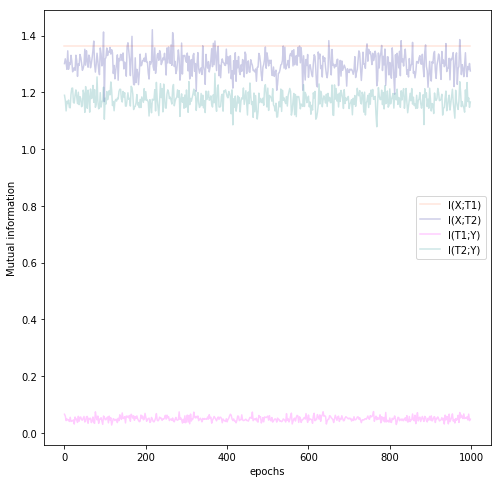

In [88]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_color_cycle(['coral', 'darkblue', 'magenta', 'teal'])
ax.set_xlabel('epochs')
ax.set_ylabel('Mutual information')
ax.plot(epochs,mi_xt_all[:,0],label='I(X;T1)',alpha=0.2)
ax.plot(epochs,mi_xt_all[:,1],label='I(X;T2)',alpha=0.2)
ax.plot(epochs,mi_ty_all[:,0],label='I(T1;Y)',alpha=0.2)
ax.plot(epochs,mi_ty_all[:,1],label='I(T2;Y)',alpha=0.2)
ax.legend()
title = ax.set_title('')
plt.show(fig)